## test+train的Fat data全用來當word2vec的訓練文本
## 不考慮出現"not"的情況( "not" 在model中相關字的意思和"not"沒有太大相關性)

In [1]:
from os import listdir
from os.path import isfile, isdir, join
from collections import Counter
import csv
import numpy
import pandas as pd
from gensim.models.word2vec import Word2Vec
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


from data_preprocess import content_fraction
from Dataloader import dataloader

In [2]:
train_data_path = "..\Case_Presentation_1_Data\Train_Textual\\"
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"

train_data = dataloader(train_data_path)
test_data  = dataloader(test_data_path)

In [3]:
print(train_data.text_list[0])

['discharg', 'summari', 'unsign', 'admiss', 'date', 'report', 'statu', 'unsign', 'discharg', 'date', 'discharg', 'diagnosi', 'coronari', 'arteri', 'diseas', 'unstabl', 'angina', 'histori', 'present', 'ill', 'hoopl', 'old', 'woman', 'statu', 'post', 'doubl', 'coronari', 'arteri', 'bypass', 'graft', 'endarterectomi', 'fourteen', 'year', 'ago', 'develop', 'angina', 'six', 'month', 'ago', 'suffer', 'unstabl', 'angina', 'sever', 'day', 'coronari', 'catheter', 'result', 'show', 'sever', 'occlus', 'saphen', 'vein', 'graft', 'occlus', 'left', 'anterior', 'descend', 'echocardiogram', 'show', 'excel', 'left', 'ventricular', 'function', 'intraaort', 'balloon', 'pump', 'place', 'reliev', 'intract', 'angina', 'past', 'medic', 'histori', 'signific', 'chest', 'pain', 'short', 'breath', 'admit', 'talc', 'commun', 'medic', 'center', 'catheter', 'coronari', 'arteri', 'bypass', 'graft', 'coronari', 'endarterectomi', 'no', 'chest', 'pain', 'six', 'month', 'prior', 'admiss', 'time', 'inder', 'aspirin', 'si

### 取train data和test data中"非肥胖"的text

In [4]:
model = Word2Vec(train_data.text_list[200:400]+test_data.text_list[200:400])

In [5]:
#定義相關性
def similar(w2v_model, word, target, topn=10):
        try:
            return w2v_model.wv.similarity(word, target)
        except:
            return 0

In [6]:
#找和 words相關性最大的前 [topn] 個字
def most_similar(w2v_model, words, topn=20):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

### 和"not"相關的前幾個字和"not"本身文義不相關

In [7]:
print(most_similar(model, ["not"]))

                   not       cos
0   treatmentsprocedur  0.825367
1             endoscop  0.820820
2                brief  0.814335
3                 none  0.790733
4                could  0.778024
5             reproduc  0.767728
6              interim  0.757878
7               detail  0.747915
8                resum  0.732646
9             procedur  0.729379
10              applic  0.718638
11                oper  0.717964
12   pericardiocentesi  0.710922
13            descript  0.704558
14       arthrocentesi  0.684125
15              though  0.682973
16                 may  0.676472
17             fiveday  0.648564
18               drive  0.646923
19             complet  0.645882


In [8]:
print(most_similar(model, ["hypercholesterolemia"]))

   hypercholesterolemia       cos
0           hypothyroid  0.965932
1             hypertens  0.963616
2        hyperlipidemia  0.951128
3              arthriti  0.938871
4         insulindepend  0.935257
5               mellitu  0.932998
6            neuropathi  0.928657
7                  iddm  0.924806
8          postmenopaus  0.921284
9                   htn  0.920597
10               seizur  0.913740
11           rheumatoid  0.913662
12          retinopathi  0.911229
13              depress  0.910394
14               asthma  0.909304
15            hyperchol  0.906539
16               disord  0.902071
17               reflux  0.902004
18              nephrot  0.898870
19                 gout  0.898852


In [9]:
print(most_similar(model, ["angina"]))

       angina       cos
0     unstabl  0.964783
1      recurr  0.929179
2      recent  0.916949
3      syncop  0.907864
4        atyp  0.893433
5       chief  0.889880
6       flare  0.886664
7         yof  0.885539
8   complaint  0.884652
9   nonischem  0.880499
10     system  0.879636
11    multipl  0.873770
12      stori  0.871812
13        bmc  0.866544
14      onset  0.865687
15       copd  0.863326
16    abscess  0.860170
17   myocardi  0.858409
18    infarct  0.857559
19    present  0.855288


---------------------------------------------------------------------------------------------------------------------------

## 計分方式

In [10]:
def score(datakind, gap, target_word):
    score=0
    total = 0
    for text in datakind:
        for word in text:
            if similar(model, word,  target_word)>gap:
                score+=similar(model, word, target_word)
        total+=score
        score=0
    average = total/200
    return average

### [gap]定義在大於多少相識性時要承認
### [target_word]定義要以哪個字為中心找相關性

In [11]:
gap = 0.85
target_word = "angina"

# Train data

## 不肥胖

In [12]:
train_unfat_score = score(train_data.text_list[0:200], gap, target_word)
print("train_unfat_score: ",train_unfat_score)

train_unfat_score:  6.147843938469887


## 肥胖

In [13]:
train_fat_score = score(train_data.text_list[200:400], gap, target_word)
print("train_fat_score: ",train_fat_score)

train_fat_score:  6.398882859945298


# Test data

## 不肥胖

In [14]:
test_unfat_score = score(test_data.text_list[0:200], gap, target_word)
print("test_unfat_score: ",test_unfat_score)

test_unfat_score:  6.132664863467216


## 肥胖

In [15]:
test_fat_score =score(test_data.text_list[200:400], gap, target_word)
print("test_fat_score: ",test_fat_score)

test_fat_score:  5.940745521187782


In [16]:
upper = (train_fat_score+test_fat_score)/2
print("upper: ",upper)

upper:  6.16981419056654


In [17]:
lower =  (train_unfat_score+test_unfat_score)/2
print("lower: ",lower)

lower:  6.140254400968551


### standard 建立判斷文章是否為Fat 的標準分數。 大於standard即為Fat，反之不是

In [18]:
standard = (upper+lower)/2
print("standard: ",standard)

standard:  6.155034295767546


---------------------------------------------------------------------------------------------------------------------------

# Validation

In [19]:
validation_data_path  = "..\Case_Presentation_1_Data\Validation\\"
validation_data  = dataloader(validation_data_path)

In [20]:
score(validation_data.text_list, gap, target_word)

1.839449099600315

In [21]:
score=0
ans = []
for text in validation_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        ans.append(0)
    else:
        ans.append(1)
    score=0

print(len(ans))

50


In [22]:
print(ans)

[0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


In [23]:
len(validation_data.text_list)

50

---------------------------------------------------------------------------------------------------------------------------

# confusion matrix & F1-score

In [24]:
from sklearn.metrics import confusion_matrix

def precision(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[0,1])

def recall(matrix):
    return matrix[0,0]/(matrix[0,0]+matrix[1,0])


def f1(matrix):
    return (2*precision(matrix)*recall(matrix))/(precision(matrix)+recall(matrix))


def confusionMatix(matrix, title):
    sns.set()
    f,ax=plt.subplots()
    #y_true = label
    #y_pred = ans
    sns.heatmap(matrix,annot=True,ax=ax, cmap = plt.cm.Blues) #畫熱力圖

    ax.set_title(title) #標題
    ax.set_xlabel('predict') #x軸
    ax.set_ylabel('true') #y軸

def print_result(matrix, title):
    print("precision: ",precision(matrix))
    print("recall: ",recall(matrix))
    print("F1-Score: ",f1(matrix))
    confusionMatix(matrix, title)
    
        

---------------------------------------------------------------------------------------------------------------------------

## train data

In [25]:
train_data_path  = "..\Case_Presentation_1_Data\Train_Textual\\"
train_data  = dataloader(train_data_path)
score=0
train_ans = []
for text in train_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        train_ans.append(0)
    else:
        train_ans.append(1)
    score=0

In [26]:
train_y_true = train_data.label_list
train_y_pred = train_ans

train_confusion_matrix = confusion_matrix(train_y_true, train_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(train_confusion_matrix[i][j])/200
train_confusion_matrix = tmp

precision:  0.375
recall:  0.4545454545454546
F1-Score:  0.4109589041095891


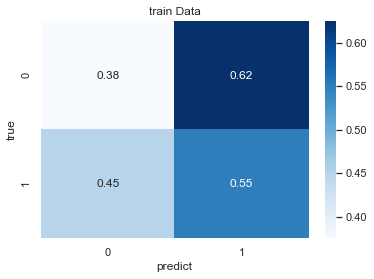

In [27]:
print_result(train_confusion_matrix, "train Data")

## test data

In [28]:
test_data_path  = "..\Case_Presentation_1_Data\Test_Intuitive\\"
test_data  = dataloader(test_data_path)
score=0
test_ans = []

for text in test_data.text_list:
    for word in text:
        if similar(model, word,  target_word)>gap:
            score+=similar(model, word, target_word)
    if score>standard:
        test_ans.append(0)
    else:
        test_ans.append(1)
    score=0

In [29]:
test_y_true = test_data.label_list
test_y_pred = test_ans

test_confusion_matrix = confusion_matrix(test_y_true, test_y_pred)
tmp = numpy.empty((2,2), dtype=float)

for i in range(2):
    for j in range(2):
        tmp[i][j] = float(test_confusion_matrix[i][j])/200
test_confusion_matrix = tmp

precision:  0.375
recall:  0.4777070063694268
F1-Score:  0.42016806722689076


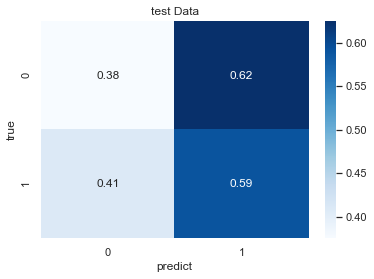

In [30]:
print_result(test_confusion_matrix, "test Data")